## Substance Classification via Personality Trait Information
Jacob Levine 

Given information regarding an individual's personality traits, can we predict whether they are at risk for using certain substances? Analyzing whether someone is more or less likely to use marijuana, nicotine and cocaine based on their psychological and emotional makeup.  

Experimentation with Multilabel Random Forest Classification. Attempting to create a multilabel model that can predict likelihood of substance use for 10 separate dependent variables. Achieved low accuracy but reasonable F1 score.


In [1522]:
#Imports
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import svm
import pickle
sns.set_style('darkgrid')
pd.set_option('max_columns', 100)

#Visualization
%pylab inline
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
from pprint import pprint

#SMOTE for unbalanced classes
from imblearn.over_sampling import SMOTE

Populating the interactive namespace from numpy and matplotlib


/Users/Jacob/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figsize', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [182]:
#Reading in Drug Consumption Dataset 
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data'
names = ['ID', 'Age', 'Gender', 'Education', 'Country',
         'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 
        'SS', 'Alc', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Weed', 'Chocolate', 
        'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ket', 'Legalh', 'LSD', 'Meth', 
        'Shrooms', 'Nicotine', 'Semer', 'VSA']

drug_df = pd.read_csv(url, header=None, names=names)

In [183]:
#Get rid of ID column 
del drug_df['ID']

In [184]:
#age_dummies = pd.get_dummies(drug_df['Age'])
#age_dummies.columns = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
#drug_df = pd.concat([drug_df, age_dummies], axis=1)
#drug_df.drop('Age', inplace=True, axis=1)

In [185]:
#Replacing 'CL' values with numeric values for easier analysis 
drug_df.replace('CL0', 0, inplace=True)
drug_df.replace('CL1', 1, inplace=True)
drug_df.replace('CL2', 2, inplace=True)
drug_df.replace('CL3', 3, inplace=True)
drug_df.replace('CL4', 4, inplace=True)
drug_df.replace('CL5', 5, inplace=True)
drug_df.replace('CL6', 6, inplace=True)

In [1954]:
# #Examining value counts for each column 
# for col in drug_df.columns:
#     print("--------------------------")
#     print(drug_df[col].value_counts().sort_index())

In [1955]:
# drug_df.dtypes

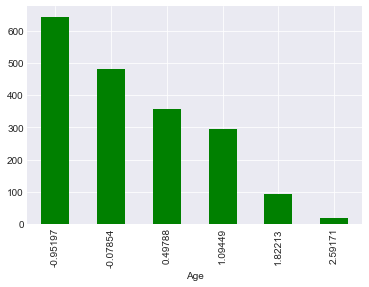

In [188]:
weed_groups = drug_df.groupby('Age')['Weed'].count()
weed_groups.plot(kind='bar', color='g')

In [1956]:
# #Drug Use by Gender
# for drug in drug_df.columns[12:]:
#     groupby = drug_df.groupby('Gender')[drug].sum()
#     print(groupby) 

In [190]:
drug_df.groupby('Age')['Heroin'].sum()

Age
-0.95197    333
-0.07854    192
 0.49788     99
 1.09449     67
 1.82213     14
 2.59171      0
Name: Heroin, dtype: int64

In [191]:
corr = drug_df.corr()

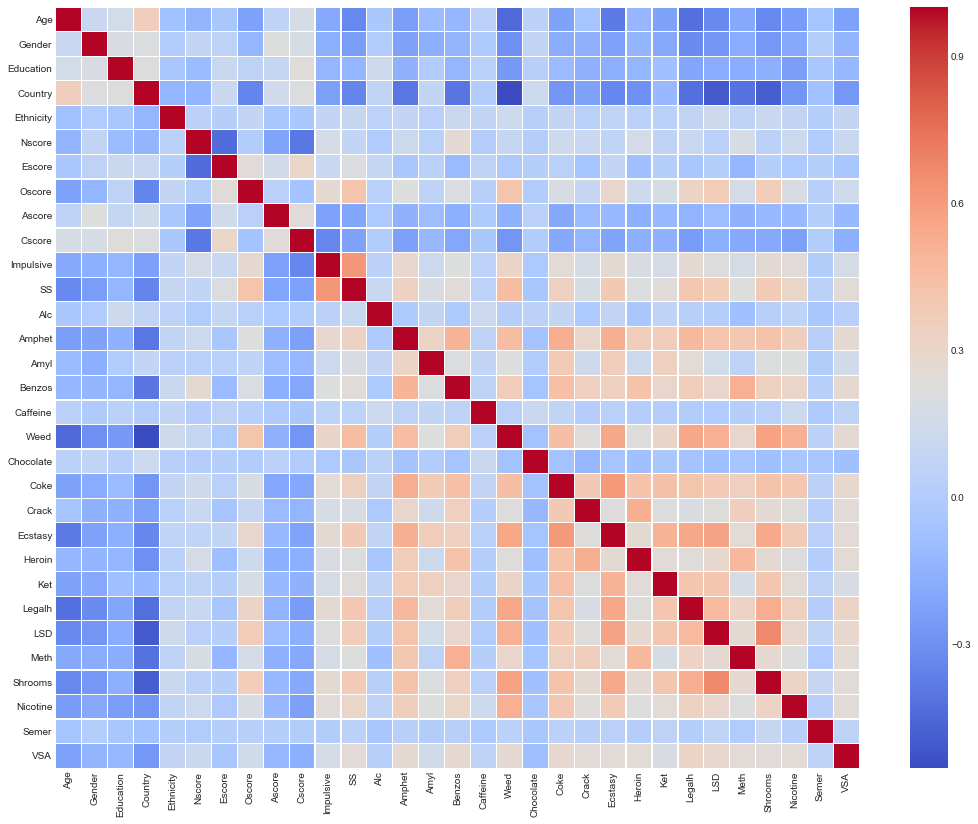

In [192]:
fig, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.2);

In [193]:
#Dummify Country column and Ethnicity column 
country_dummies = pd.get_dummies(drug_df['Country'])
country_dummies.columns = ['USA', 'NZ', 'Other', 'Australia', 'Ireland', 'Canada', 'UK']
country_dummies

,USA,NZ,Other,Australia,Ireland,Canada,UK
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
5,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0
7,0,0,0,0,0,0,1
8,0,0,0,0,0,1,0
9,0,0,0,0,0,0,1


In [194]:
drug_df = pd.concat([drug_df, country_dummies], axis=1)
#drug_df

In [195]:
#Dummify Ethnicity column 
ethnicity_dummies = pd.get_dummies(drug_df['Ethnicity'])
ethnicity_dummies.columns = ['Black', 'Asian', 'White', 'Mixed_WB', 'Other', 'Mixed_WA', 'Mixed_BA']

In [196]:
drug_df = pd.concat([drug_df, ethnicity_dummies], axis=1)
#drug_df

In [1957]:
# drug_df.Nscore.value_counts().sort_index()

In [198]:
drug_df.drop(['Country', 'Ethnicity'], axis=1, inplace=True)

## First Model Attempt

Let's look at the 'Weed' Column. I want to predict weed use only, based on all my features. 

In [199]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
np.set_printoptions(threshold=np.nan)

In [200]:
#classification with weed column as y 
y = drug_df.Weed
X = drug_df.drop('Weed', axis=1)

logreg = LogisticRegression(C=1e9, multi_class='ovr')
logreg.fit(X, y)
y_pred = logreg.predict(X)

In [201]:
metrics.accuracy_score(y, y_pred)

0.50663129973474796

In [202]:
#Dropping Certain drug columns that I do not want to work with 
drug_df.drop(['Semer', 'VSA'], axis=1, inplace=True)
drug_df.drop(['Amyl', 'Legalh'], axis=1, inplace=True)

# Binarize the drug columns

Binary predictions for the various drug classes.   
0 - Non User  
1 - User 

In [211]:
#2 is threshold
thresh = 2
drug_df.columns
drug_columns = drug_df.columns[10:25]
for col in drug_columns:
    drug_df[col] = np.where(drug_df[col] > thresh, 1, 0)

In [464]:
#Creating copy df
drug_df_copy = drug_df.copy()

In [1958]:
# for col in drug_columns:
#     print(drug_df_copy[col].value_counts())

# Logistic Regression - Weed - All Features 
Cross Validation Process 

In [966]:
drug_df_copy.columns

Index(['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore',
       'Cscore', 'Impulsive', 'SS', 'Alc', 'Amphet', 'Benzos', 'Caffeine',
       'Weed', 'Chocolate', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ket', 'LSD',
       'Meth', 'Shrooms', 'Nicotine', 'USA', 'NZ', 'Other', 'Australia',
       'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed_WB',
       'Other', 'Mixed_WA', 'Mixed_BA'],
      dtype='object')

In [996]:
X = drug_df_copy.drop('Weed', axis=1)
y = drug_df_copy.loc[:, 'Weed']

In [997]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [998]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1319, 38)
(566, 38)
(1319,)
(566,)


In [999]:
#Standardize the personality trait features before running random forests
scaler = StandardScaler()
#Scale X dataset for random forests
scaler.fit(X_train)
#Transform train
X_train_scaled = scaler.transform(X_train)
#Transform test 
X_test_scaled = scaler.transform(X_test)

#Logistic Regression with personality type features as categorical 
logreg2 = LogisticRegression(C=1e9)
logreg2.fit(X_train_scaled, y_train)
y_pred = logreg2.predict(X_test_scaled)

In [1069]:
print("Logistic Regression Test Accuracy Weed All Features:", metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Logistic Regression Test Accuracy Weed All Features: 0.871024734982
[[255  27]
 [ 46 238]]
             precision    recall  f1-score   support

          0       0.85      0.90      0.87       282
          1       0.90      0.84      0.87       284

avg / total       0.87      0.87      0.87       566



In [1001]:
list(zip(X_test.columns, logreg2.coef_[0]))

[('Age', -0.41020150875808853),
 ('Gender', -0.23070885645088701),
 ('Education', -0.2762444409424874),
 ('Nscore', -0.22377035299586007),
 ('Escore', -0.26933737614173792),
 ('Oscore', 0.60633212071997278),
 ('Ascore', 0.041590992832907757),
 ('Cscore', -0.28376564545762539),
 ('Impulsive', -0.16579324943145998),
 ('SS', 0.46854738583895328),
 ('Alc', 0.03547228937802608),
 ('Amphet', 0.17923191024922297),
 ('Benzos', 0.079373976217026632),
 ('Caffeine', -0.057590684373460835),
 ('Chocolate', -0.022661037145745917),
 ('Coke', 0.22642891459237088),
 ('Crack', 0.09244764599210481),
 ('Ecstasy', 0.4257933060064808),
 ('Heroin', -0.15491995933313155),
 ('Ket', 0.091272990886714728),
 ('LSD', 0.15011956478888985),
 ('Meth', 0.066488278520204336),
 ('Shrooms', 0.52790825401303121),
 ('Nicotine', 0.73117299644259015),
 ('USA', 0.34678074260629038),
 ('NZ', -0.010921465726570913),
 ('Other', -0.10004122340634534),
 ('Australia', 0.075459725377341053),
 ('Ireland', -0.039818115427324281),
 ('C

In [1002]:
cross_val_scores = cross_val_score(logreg2, X_test, y_test, cv=10)

In [1003]:
np.mean(cross_val_scores)

0.86958992308357086

In [1004]:
drug_df_copy.columns

Index(['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore',
       'Cscore', 'Impulsive', 'SS', 'Alc', 'Amphet', 'Benzos', 'Caffeine',
       'Weed', 'Chocolate', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ket', 'LSD',
       'Meth', 'Shrooms', 'Nicotine', 'USA', 'NZ', 'Other', 'Australia',
       'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed_WB',
       'Other', 'Mixed_WA', 'Mixed_BA'],
      dtype='object')

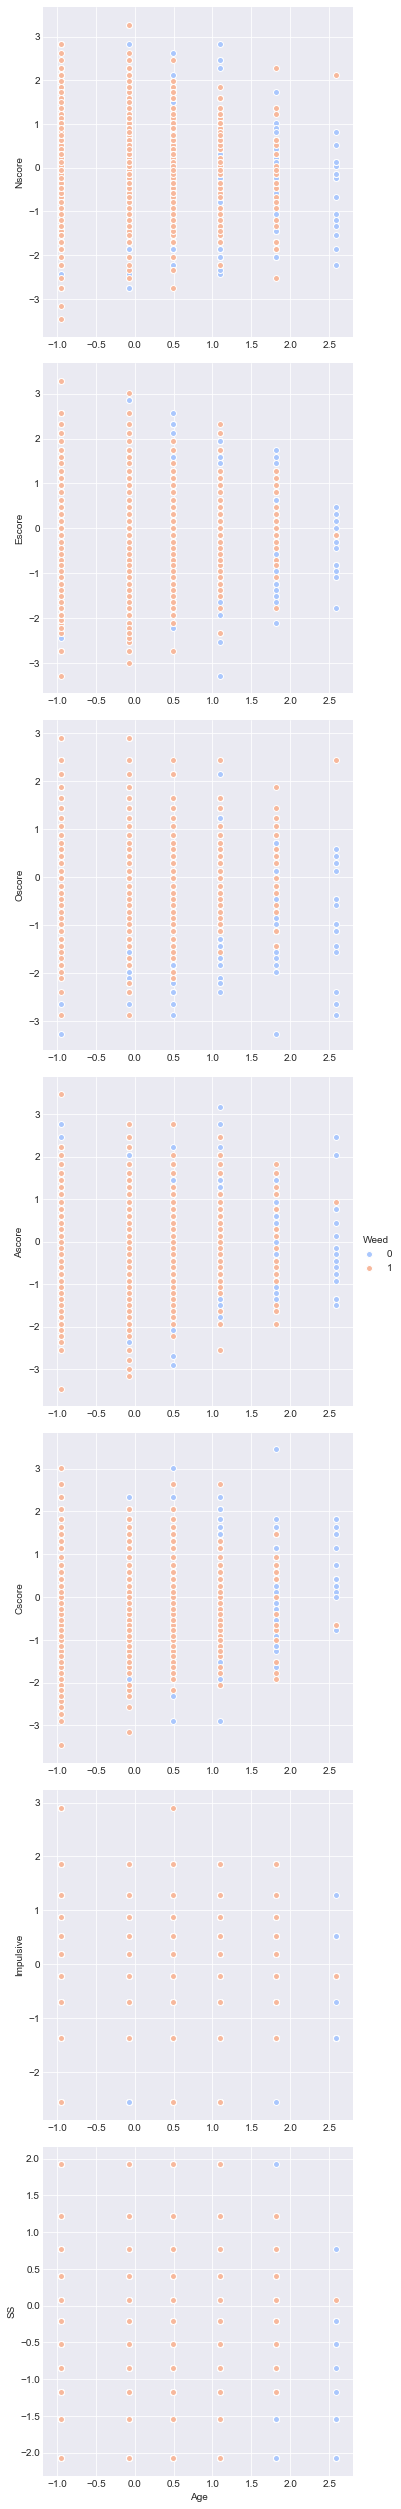

In [483]:
#Pairplot - Age
sns.pairplot(drug_df_copy, x_vars=("Age"), 
             y_vars=("Nscore",'Escore','Oscore','Ascore', 'Cscore', 'Impulsive', 'SS'),
             hue="Weed", palette='coolwarm', size=5);

### Decision Trees, Random Forests

In [491]:
#Decision Tree Classifier 
tree1 = DecisionTreeClassifier(max_depth=3, random_state=1234)
tree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

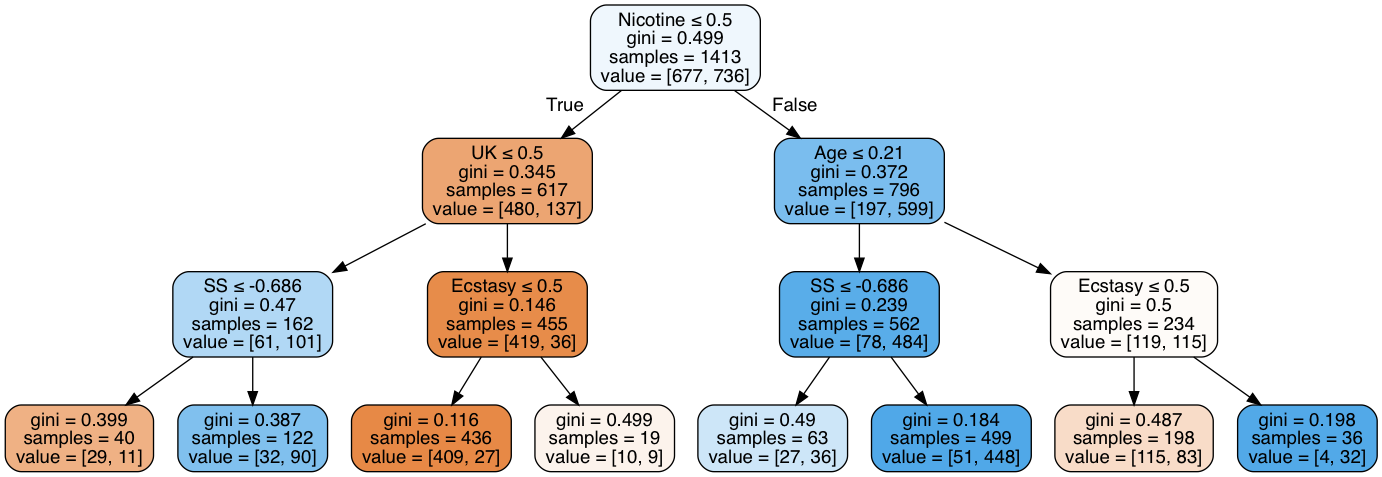

In [492]:
dot_data = StringIO()  
export_graphviz(tree1, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
occ_graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(occ_graph.create_png())

In [493]:
y_pred_tree = tree1.predict(X_test)
print("Decision Tree Test Accuracy Score:", accuracy_score(y_test, y_pred_tree))

Decision Tree Test Accuracy Score: 0.783898305085


In [494]:
pd.DataFrame({'feature':X_test.columns, 'importance':tree1.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
23,Nicotine,0.549461
30,UK,0.198854
0,Age,0.126891
9,SS,0.069702
17,Ecstasy,0.055093
28,Ireland,0.000000
22,Shrooms,0.000000
24,USA,0.000000
25,NZ,0.000000
26,Other,0.000000


## Random Forest

In [1066]:
#Random Forest - using all features
rf = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True, random_state=1234)
rf.fit(X_train_all, y_train_all)
y_test_rf_pred = rf.predict(X_test_all)
#y_test_rf_pred
print("Random Forest Test Accuracy Score:", accuracy_score(y_test_all, y_test_rf_pred))

Random Forest Test Accuracy Score: 0.842756183746


In [1067]:
print("Feature Importance for Weed - Only Random Forest:")
pd.DataFrame({'Feature':X_test_all.columns,
              'Importance':rf.feature_importances_}).sort_values(by='Importance', ascending=False)


Feature Importance for Weed - Only Random Forest:


,Feature,Importance
23,Nicotine,0.112177
30,UK,0.095212
17,Ecstasy,0.087215
9,SS,0.068153
24,USA,0.056516
5,Oscore,0.056447
0,Age,0.055119
7,Cscore,0.054941
22,Shrooms,0.045828
3,Nscore,0.042884


In [1068]:
#Confusion Matrix
#Classification Report
print(metrics.confusion_matrix(y_test_all, y_test_rf_pred))
print(metrics.classification_report(y_test_all, y_test_rf_pred))

[[216  50]
 [ 39 261]]
             precision    recall  f1-score   support

          0       0.85      0.81      0.83       266
          1       0.84      0.87      0.85       300

avg / total       0.84      0.84      0.84       566



In [795]:
drug_df.columns

Index(['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore',
       'Cscore', 'Impulsive', 'SS', 'Alc', 'Amphet', 'Benzos', 'Caffeine',
       'Weed', 'Chocolate', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ket', 'LSD',
       'Meth', 'Shrooms', 'Nicotine', 'USA', 'NZ', 'Other', 'Australia',
       'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed_WB',
       'Other', 'Mixed_WA', 'Mixed_BA'],
      dtype='object')

# Optimizing the Marijuana Model

Weed is a pretty balanced class. We can observe ROC/AUC curves for various algorithms.    
Use all features for marijuana.   
Logistic Regression  
Random Forest  
SVM  
Naive Bayes 


### Logistic Regression Weed - Personality Traits Only 

In [1105]:
#Logistic Regression with personality type features as numeric (not categorical)
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y = drug_df.loc[:, 'Weed']
X_train_weed, X_test_weed, y_train_weed, y_test_weed = train_test_split(X, y, test_size = 0.3, random_state=1234)
logreg_weed_personality_only = LogisticRegression(C=1e9)
logreg_weed_personality_only.fit(X_train_weed, y_train_weed)
y_pred_weed = logreg_weed_personality_only.predict(X_test_weed)

In [1222]:
print(metrics.accuracy_score(y_test_weed, y_pred_weed))
print(metrics.confusion_matrix(y_test_weed, y_pred_weed))
lr_predicted_probs_weed = logreg_weed_personality_only.predict_proba(X_test_weed)
#list(zip(X_train_weed.columns, logreg_weed_personality_only.coef_[0]))

0.498233215548
[[114 143]
 [141 168]]


In [1921]:
##Trying my hand at some predictions using ONLY personality trait features## 
## RANDOM FOREST ##
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_weed = drug_df.loc[:, 'Weed']
X_train_weed, X_test_weed, y_train_weed, y_test_weed = train_test_split(X, y_weed,
                                                                        test_size = 0.3)

#Standardize the personality trait features before running random forests
scaler = StandardScaler()
#Scale X dataset for random forests
scaler.fit(X_train_weed)
#Transform train
X_train_scaled_weed = scaler.transform(X_train_weed)
#Transform test 
X_test_scaled_weed = scaler.transform(X_test_weed)

#Model
rf_weed = RandomForestClassifier(n_estimators=500, bootstrap=True)
rf_weed.fit(X_train_scaled_weed, y_train_weed)
y_weed_pred = rf_weed.predict(X_test_scaled_weed)
print("Random Forest Weed Test Accuracy Score:", accuracy_score(y_test_weed, y_weed_pred))
print("Feature Importance for Weed - Only Random Forest:")
print(pd.DataFrame({'Feature':X_test_weed.columns,
              'Importance':rf_weed.feature_importances_}).sort_values(by='Importance', ascending=False))
#Confusion Matrix for the Personality traits only weed model 
print(metrics.confusion_matrix(y_test_weed, y_weed_pred))
print(metrics.classification_report(y_test_weed, y_weed_pred))

#Predict Probabilities 
print(X_test.columns)
weed_probs_personality_only = rf_weed.predict_proba([[-2, -2, 0, 1, 1, 1, 0]])[0]
print("0: Non User")
print("1: User")
for i in list(zip(rf_weed.classes_, weed_probs_personality_only)):
    print(i)

rf_predicted_probs_weed = rf_weed.predict_proba(X_test_weed)

Random Forest Weed Test Accuracy Score: 0.765017667845
Feature Importance for Weed - Only Random Forest:
     Feature  Importance
6         SS    0.196591
2     Oscore    0.184663
4     Cscore    0.151157
0     Nscore    0.137597
1     Escore    0.121799
3     Ascore    0.116223
5  Impulsive    0.091970
[[207  78]
 [ 55 226]]
             precision    recall  f1-score   support

          0       0.79      0.73      0.76       285
          1       0.74      0.80      0.77       281

avg / total       0.77      0.77      0.76       566

Index(['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore',
       'Cscore', 'Impulsive', 'SS', 'Alc', 'Amphet', 'Benzos', 'Caffeine',
       'Chocolate', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ket', 'LSD', 'Meth',
       'Shrooms', 'Nicotine', 'USA', 'NZ', 'Other', 'Australia', 'Ireland',
       'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed_WB', 'Other',
       'Mixed_WA', 'Mixed_BA'],
      dtype='object')
0: Non User
1: User
(0, 

In [1948]:
metrics.recall_score(y_test_weed, y_weed_pred)

0.80427046263345192

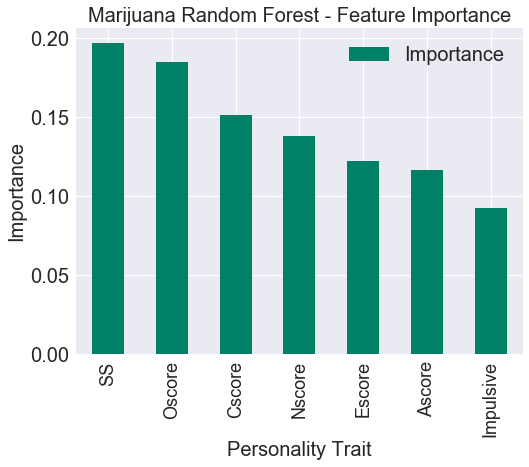

In [1961]:
rf_weed_feature_importance = pd.DataFrame({'Feature':X_test_weed.columns,
              'Importance':rf_weed.feature_importances_}).sort_values(by='Importance', ascending=False)
#Plot
rf_weed_feature_importance.plot("Feature", "Importance", kind='bar',
                                figsize=(8, 6), colormap='summer')
plt.title("Marijuana Random Forest - Feature Importance", fontsize=20)
plt.ylabel("Importance", fontsize=20)
plt.xlabel("Personality Trait", fontsize=20)
plt.xticks(fontsize=18);
#plt.savefig("rf_weed.pdf");

Text(0.5,1,'Random Forest Confusion Matrix - Marijuana')

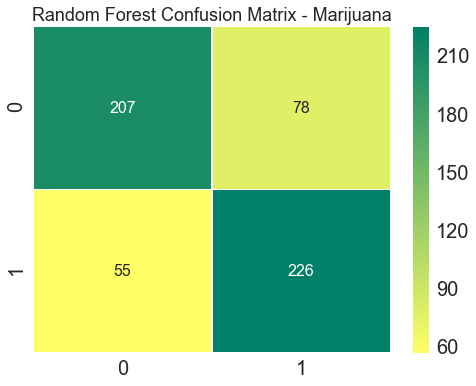

In [1940]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=2)
sns.heatmap(metrics.confusion_matrix(y_test_weed, y_weed_pred), annot=True,
            linewidths=0.5, robust=True, cmap='summer_r', fmt='d', annot_kws={"size": 16})
plt.title("Random Forest Confusion Matrix - Marijuana", fontsize=18)
#plt.savefig("Random_Forest_Confusion_Matrix.pdf");

In [1924]:
#Predict Probabilities 
print(X_test.columns)
weed_probs_personality_only = rf_weed.predict_proba([[-2, -1, 0, 1, 1, 1, 0]])[0]
print("0: Non User")
print("1: User")
for i in list(zip(rf_weed.classes_, weed_probs_personality_only)):
    print(i)

Index(['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore',
       'Cscore', 'Impulsive', 'SS', 'Alc', 'Amphet', 'Benzos', 'Caffeine',
       'Chocolate', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ket', 'LSD', 'Meth',
       'Shrooms', 'Nicotine', 'USA', 'NZ', 'Other', 'Australia', 'Ireland',
       'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed_WB', 'Other',
       'Mixed_WA', 'Mixed_BA'],
      dtype='object')
0: Non User
1: User
(0, 0.45400000000000001)
(1, 0.54600000000000004)


In [1928]:
rf_weed.feature_names = ['Neuroticism: Neurotic individuals are likely to experience feelings \
of anxiety, worry, depression, loneliness and guilt.',
                         'Extraversion: Extroverted individuals tend to be more outgoing and social. They recharge around other people.', 
                         'Openness: Imaginative, curious and open-minded people. Attentiveness to inner feelings and focused on trying new things.',
                         'Agreeableness: Agreeable individuals tend to be more empathetic, caring and cooperative towards other people.', 
                         'Conscientiousness: Goal-oriented, diligent individuals that enjoy having a set schedule and structure. Strong attention to detail.',
                         'Impulsiveness: Impulsive individuals tend to display behavior characterized by having little or no forethought of the consequences of their actions.',
                         'Sensation-Seeking: Excitement-seeking individuals that are easily bored without high levels of stimulation.']
rf_weed.feature_names
targets = ["Non-User", "User"]
rf_weed.target_names = targets
rf_weed.target_names

['Non-User', 'User']

In [1929]:
rf_weed.feature_names

['Neuroticism: Neurotic individuals are likely to experience feelings of anxiety, worry, depression, loneliness and guilt.',
 'Extraversion: Extroverted individuals tend to be more outgoing and social. They recharge around other people.',
 'Openness: Imaginative, curious and open-minded people. Attentiveness to inner feelings and focused on trying new things.',
 'Agreeableness: Agreeable individuals tend to be more empathetic, caring and cooperative towards other people.',
 'Conscientiousness: Goal-oriented, diligent individuals that enjoy having a set schedule and structure. Strong attention to detail.',
 'Impulsiveness: Impulsive individuals tend to display behavior characterized by having little or no forethought of the consequences of their actions.',
 'Sensation-Seeking: Excitement-seeking individuals that are easily bored without high levels of stimulation.']

In [1962]:
## For Flask App - Practice ##
# personality_names = ['Neuroticism', 'Extraversion', 'Openness', 
#                      'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation-Seeking']
# test_vals = [0, 3, 1, 5, 3, 2, 4]
# pd.DataFrame({"Personality Traits": personality_names, "Scores": test_vals})

In [1515]:
#Pickling
#with open("rf_weed.pkl", "wb") as f:
#    pickle.dump(rf_weed, f)

In [1516]:
#Testing opening pickled model 
#with open("rf_weed.pkl", "rb") as f:
#    rf_weed_pickle = pickle.load(f)

In [1460]:
rf_weed_pickle.feature_names

['Neuroticism:',
 'Extraversion:',
 'Openness:',
 'Agreeableness:',
 'Conscientiousness:',
 'Impulsiveness:',
 'Sensation-Seeking:']

In [1953]:
#Linear Support Vector Machine
lin_svm = svm.SVC(kernel='linear', probability=True)
lin_svm.fit(X_train_scaled_weed, y_train_weed)
print(lin_svm.score(X_test_scaled_weed, y_test_weed))
lin_svm_pred_weed = lin_svm.predict(X_test_scaled_weed)

lin_svm_predicted_probs_weed = lin_svm.predict_proba(X_test_scaled_weed)
print(metrics.confusion_matrix(y_test_weed, lin_svm_pred_weed))
print(metrics.classification_report(y_test_weed, lin_svm_pred_weed))
print("Recall", metrics.recall_score(y_test_weed, lin_svm_pred_weed))
print("Precision", metrics.precision_score(y_test_weed, lin_svm_pred_weed))
#print(metrics.precision_recall_curve(y_test_weed, lin_svm_pred_weed))

0.765017667845
[[210  75]
 [ 58 223]]
             precision    recall  f1-score   support

          0       0.78      0.74      0.76       285
          1       0.75      0.79      0.77       281

avg / total       0.77      0.77      0.76       566

Recall 0.79359430605
Precision 0.748322147651


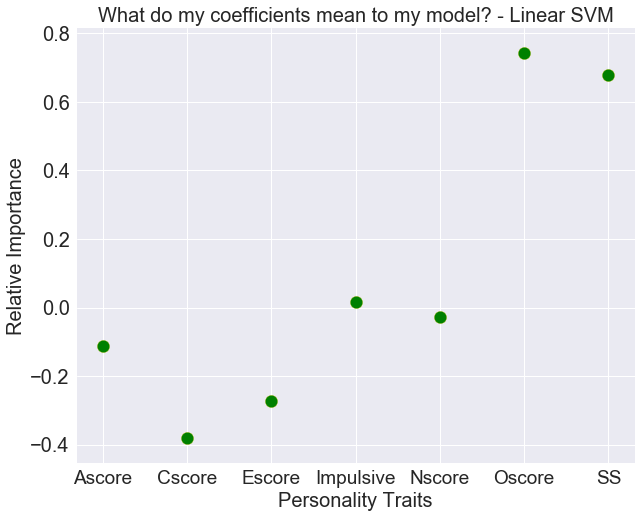

In [1913]:
fig, ax = plt.subplots(figsize=(10, 8))
list(zip(X_test_weed.columns, lin_svm.coef_[0]))
plt.scatter(X_test_weed.columns, lin_svm.coef_[0], s=150, c='g', edgecolor='y')
plt.xticks(fontsize=19)
plt.yticks(fontsize=20)
plt.xlabel("Personality Traits", fontsize=20)
plt.ylabel("Relative Importance", fontsize=20)
plt.title("What do my coefficients mean to my model? - Linear SVM", fontsize=20);
#plt.savefig("lin_svm_coef_.pdf");

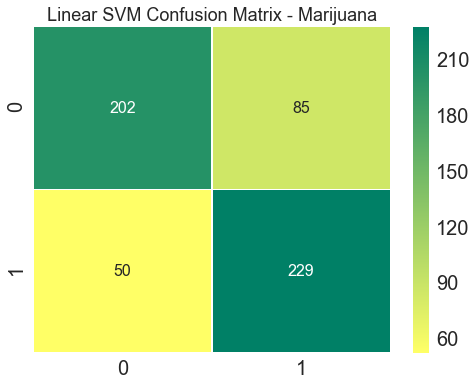

In [1914]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=2)
sns.heatmap(metrics.confusion_matrix(y_test_weed, lin_svm_pred_weed), annot=True,
            linewidths=0.5, robust=True, cmap="summer_r", fmt='d', annot_kws={"size": 16})
plt.title("Linear SVM Confusion Matrix - Marijuana", fontsize=18);
#plt.savefig("linsvm_confusion_matrix.pdf");

In [1963]:
#RBF Support Vector Machine
rbf_svm = svm.SVC(kernel='rbf', probability=True)
rbf_svm.fit(X_train_scaled_weed, y_train_weed)
print(rbf_svm.score(X_test_scaled_weed, y_test_weed))
rbf_svm_pred_weed = rbf_svm.predict(X_test_scaled_weed)

rbf_svm_predicted_probs_weed = rbf_svm.predict_proba(X_test_scaled_weed)
print(metrics.confusion_matrix(y_test_weed, rbf_svm_pred_weed))
print(metrics.classification_report(y_test_weed, rbf_svm_pred_weed))


0.772084805654
[[206  79]
 [ 50 231]]
             precision    recall  f1-score   support

          0       0.80      0.72      0.76       285
          1       0.75      0.82      0.78       281

avg / total       0.78      0.77      0.77       566



In [1964]:
#Naive Bayes
from sklearn import naive_bayes
naive_gauss_weed = naive_bayes.GaussianNB()
naive_gauss_weed.fit(X_train_scaled_weed, y_train_weed)
print(naive_gauss_weed.score(X_test_scaled_weed, y_test_weed))
naive_gauss_weed_pred = naive_gauss_weed.predict(X_test_scaled_weed)

nb_predicted_probs_weed = naive_gauss_weed.predict_proba(X_test_scaled_weed)
print(metrics.confusion_matrix(y_test_weed, naive_gauss_weed_pred))
print(metrics.classification_report(y_test_weed, naive_gauss_weed_pred))

0.754416961131
[[208  77]
 [ 62 219]]
             precision    recall  f1-score   support

          0       0.77      0.73      0.75       285
          1       0.74      0.78      0.76       281

avg / total       0.76      0.75      0.75       566



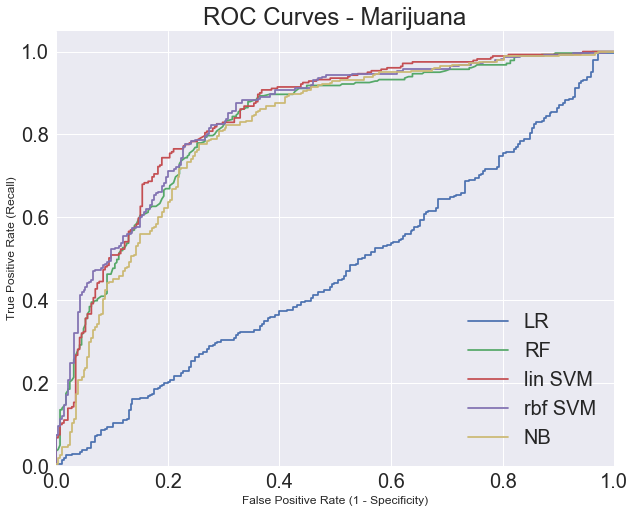

In [1965]:
## ROC/AUC EVALUATION ##
#generate Logistic Regression model false positive and true positive rates
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test_weed, lr_predicted_probs_weed[:,1])

#random forest
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test_weed, rf_predicted_probs_weed[:,1])

#SVM - LIN
fpr_svmlin, tpr_svmlin, thresholds_svmlin = metrics.roc_curve(y_test_weed, lin_svm_predicted_probs_weed[:,1])

#SVM - RBF 
fpr_svmrbf, tpr_svmrbf, thresholds_svmrbf = metrics.roc_curve(y_test_weed, rbf_svm_predicted_probs_weed[:,1])

#Naive Bayes
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test_weed, nb_predicted_probs_weed[:,1])


# plot model ROC curves
plt.figure(figsize=(10, 8))
plot(fpr_lr, tpr_lr, label="LR")
plot(fpr_rf, tpr_rf, label="RF")
plot(fpr_svmlin, tpr_svmlin, label='lin SVM')
plot(fpr_svmrbf, tpr_svmrbf, label='rbf SVM')
plot(fpr_nb, tpr_nb, label='NB')
title('ROC Curves - Marijuana')
xlim([0, 1])
ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12);
#plt.savefig('ROC_weed.pdf');

In [1966]:
print("Linear SVM is best.")
print("-" * 30)
print("Linear SVM AUC:", metrics.roc_auc_score(y_test_weed, lin_svm_predicted_probs_weed[:,1]))
print("RBF SVM AUC:", metrics.roc_auc_score(y_test_weed, rbf_svm_predicted_probs_weed[:,1]))
print("NB AUC:", metrics.roc_auc_score(y_test_weed, nb_predicted_probs_weed[:,1]))
print("Random Forest AUC:", metrics.roc_auc_score(y_test_weed, rf_predicted_probs_weed[:,1]))
print("Logistic Regression AUC:", metrics.roc_auc_score(y_test_weed, lr_predicted_probs_weed[:,1]))

Linear SVM is best.
------------------------------
Linear SVM AUC: 0.839245801336
RBF SVM AUC: 0.838234375976
NB AUC: 0.809577324093
Random Forest AUC: 0.824118124493
Logistic Regression AUC: 0.469863270275


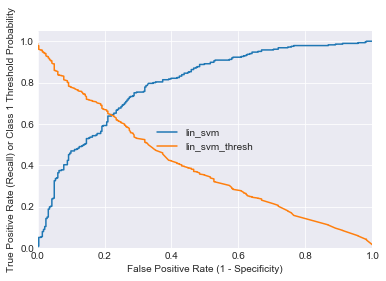

In [1588]:
#Lets look at Precision/Recall curve for Linear SVM 
sns.mpl.pyplot.plot(fpr_svmlin, tpr_svmlin,label="lin_svm")
sns.mpl.pyplot.plot(fpr_svmlin,thresholds_svmlin, label="lin_svm_thresh")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="center")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Recall) or Class 1 Threshold Probability');

In [1578]:
#Grid Search 
from sklearn.model_selection import GridSearchCV

In [1967]:
# param_grid = {
#     "C": np.logspace(5,-5,11)
# }

# lin_grid = GridSearchCV(lin_svm, param_grid, verbose=2, n_jobs=-1)
# lin_grid.fit(X_test_scaled_weed, y_test_weed)

In [1581]:
print(f"""
best params: {lin_grid.best_params_}
best score: {lin_grid.best_score_}
""")


best params: {'C': 100000.0}
best score: 0.7173144876325088



In [1173]:
y_test_linsvm_df.head(5)

,class_0,class_1,predicted,actual,predicted_06,predicted_02
0,0.725158,0.274842,0.0,1.0,0.0,1.0
1,0.250849,0.749151,1.0,1.0,1.0,1.0
2,0.717592,0.282408,0.0,0.0,0.0,1.0
3,0.500000,0.500000,0.0,1.0,0.0,1.0
4,0.957703,0.042297,0.0,0.0,0.0,0.0


In [1323]:
#Playing with threshold on Linear SVM 
y_test_linsvm_df = pd.DataFrame(
    np.concatenate((
        lin_svm_predicted_probs_weed, 
        lin_svm_pred_weed.reshape((lin_svm_pred_weed.shape[0],-1)),
        y_test_weed.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

#Setting a new threshold value 
y_test_linsvm_df["predicted_06"] = (y_test_linsvm_df.class_1 > 0.61).astype(float) #False positives 

y_test_linsvm_df["predicted_02"] = (y_test_linsvm_df.class_1 > 0.185).astype(float) #False negatives 


print(y_test_linsvm_df.head(5))
print()

print("Confusion matrix at original 0.5 threshold:\n",metrics.confusion_matrix(y_test_linsvm_df.actual,
                                                                      y_test_linsvm_df.predicted),"\n")

print("Classification Report at original 0.5 threshold:\n", 
      metrics.classification_report(y_test_linsvm_df.actual,y_test_linsvm_df.predicted),"\n")

print("Confusion matrix at 0.2 threshold:\n",metrics.confusion_matrix(y_test_linsvm_df.actual,
                                                                      y_test_linsvm_df.predicted_02),"\n")

print("Classification Report at 0.2 threshold:\n", metrics.classification_report(y_test_linsvm_df.actual,
                                                                                 y_test_linsvm_df.predicted_02),"\n")

    class_0   class_1  predicted  actual  predicted_06  predicted_02
0  0.725158  0.274842        0.0     1.0           0.0           1.0
1  0.250849  0.749151        1.0     1.0           1.0           1.0
2  0.717592  0.282408        0.0     1.0           0.0           1.0
3  0.500000  0.500000        0.0     0.0           0.0           1.0
4  0.957703  0.042297        0.0     1.0           0.0           0.0

Confusion matrix at original 0.5 threshold:
 [[131 126]
 [141 168]] 

Classification Report at original 0.5 threshold:
              precision    recall  f1-score   support

        0.0       0.48      0.51      0.50       257
        1.0       0.57      0.54      0.56       309

avg / total       0.53      0.53      0.53       566
 

Confusion matrix at 0.2 threshold:
 [[ 56 201]
 [ 50 259]] 

Classification Report at 0.2 threshold:
              precision    recall  f1-score   support

        0.0       0.53      0.22      0.31       257
        1.0       0.56      0.84      0

In [1181]:
list(zip(X_train_weed.columns, lin_svm.coef_[0]))

[('Nscore', -0.11294929170182044),
 ('Escore', -0.28871057085669261),
 ('Oscore', 0.7501368860538733),
 ('Ascore', -0.098805817210690705),
 ('Cscore', -0.42456001543634159),
 ('Impulsive', -0.043037323592972854),
 ('SS', 0.76185977883165634)]

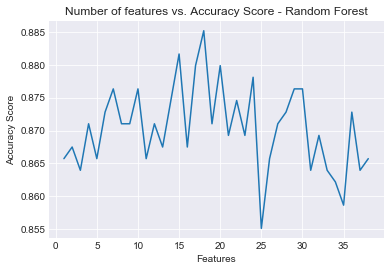

In [1296]:
#Plotting max_features vs. accuracy

### RANDOM FOREST ### 
feature_range = range(1, len(X_test.columns)+1)

accuracy_scores = []

for feature in feature_range:
    randfor = RandomForestClassifier(n_estimators=50, bootstrap=True, 
                                    oob_score=True, max_features=feature, 
                                    random_state=1234)
    randfor.fit(X_train, y_train)
    predictions = randfor.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    
plot(feature_range, accuracy_scores)
xlabel("Features")
ylabel("Accuracy Score")
title('Number of features vs. Accuracy Score - Random Forest');

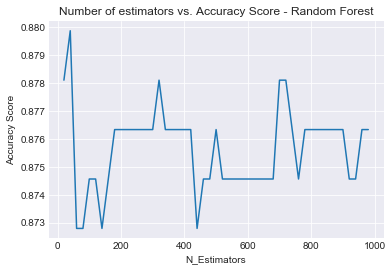

In [1297]:
#Plotting number of estimators vs. accuracy score
estimator_range = range(20, 1000, 20) 

accuracy_scores = []

for e in estimator_range:
    randfor = RandomForestClassifier(n_estimators=e, bootstrap=True, 
                                    oob_score=True, random_state=1234)
    randfor.fit(X_train, y_train)
    predictions = randfor.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    
plot(estimator_range, accuracy_scores)
xlabel("N_Estimators")
ylabel("Accuracy Score")
title('Number of estimators vs. Accuracy Score - Random Forest');

## Building Personality-trait-only models for classes of choice 

Alcohol, Benzos, Coke, Ecstasy, Heroin, Ketamine, LSD, Shrooms, Nicotine

Alcohol

In [619]:
drug_df.head()

,Age,Gender,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alc,Amphet,Benzos,Caffeine,Weed,Chocolate,Coke,Crack,Ecstasy,Heroin,Ket,LSD,Meth,Shrooms,Nicotine,USA,NZ,Other,Australia,Ireland,Canada,UK,Black,Asian,White,Mixed_WB,Other,Mixed_WA,Mixed_BA
0,0.49788,0.48246,-0.05921,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,-0.07854,-0.48246,1.98437,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0.49788,-0.48246,-0.05921,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,-0.95197,0.48246,1.16365,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0.49788,0.48246,1.98437,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [1349]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_alc = drug_df.Alc
y_alc.value_counts()
X_train_alc, X_test_alc, y_train_alc, y_test_alc = train_test_split(X, y_alc, test_size=0.3)

In [1350]:
drug_df.Alc.value_counts()

1    1749
0     136
Name: Alc, dtype: int64

In [1351]:
#SMOTE
#sm = SMOTE(random_state=1234)
#X_train_alc, y_train_alc = sm.fit_sample(X_train_alc, y_train_alc)

#Standardize the personality trait features before running random forests
scaler = StandardScaler()
#Scale X dataset for random forests
scaler.fit(X_train_alc)
#Transform train
X_train_scaled_alc = scaler.transform(X_train_alc)
#Transform test 
X_test_scaled_alc = scaler.transform(X_test_alc)
#Model
rf_alc = RandomForestClassifier(n_estimators=500)
rf_alc.fit(X_train_scaled_alc, y_train_alc)
alc_pred = rf_alc.predict(X_test_scaled_alc)
metrics.accuracy_score(y_test_alc, alc_pred)

0.93992932862190814

In [1352]:
pd.DataFrame({'Feature':X.columns,
              'Importance':rf_alc.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
4,Cscore,0.165842
2,Oscore,0.163296
1,Escore,0.156565
0,Nscore,0.155954
3,Ascore,0.155461
6,SS,0.106084
5,Impulsive,0.096799


In [1342]:
print(metrics.confusion_matrix(y_test_alc, alc_pred))
print(metrics.classification_report(y_test_alc, alc_pred))
print(metrics.f1_score(y_test_alc, alc_pred, average='weighted'))

[[  0  31]
 [  1 534]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        31
          1       0.95      1.00      0.97       535

avg / total       0.89      0.94      0.92       566

0.91773209123


In [1347]:
#support vector machine for alcohol 
#Linear SVM for Cocaine
lin_svm_alc = svm.SVC(kernel='linear', probability=True)
lin_svm_alc.fit(X_train_alc, y_train_alc)
print(lin_svm_alc.score(X_test_alc, y_test_alc))
lin_svm_pred_alc = lin_svm_alc.predict(X_test_alc)

lin_svm_predicted_probs_alc = lin_svm.predict_proba(X_test_alc)
print(metrics.confusion_matrix(y_test_alc, lin_svm_pred_alc))
print(metrics.classification_report(y_test_alc, lin_svm_pred_alc))
list(zip(X_test_alc.columns, lin_svm_alc.coef_[0]))

0.945229681979
[[  0  31]
 [  0 535]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        31
          1       0.95      1.00      0.97       535

avg / total       0.89      0.95      0.92       566



/Users/Jacob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[('Nscore', -2.2522393853918743e-05),
 ('Escore', 2.1241341745081854e-05),
 ('Oscore', -2.8236318762253632e-05),
 ('Ascore', 5.6135185934280685e-05),
 ('Cscore', -1.5131378125587958e-05),
 ('Impulsive', -1.9924119825986963e-05),
 ('SS', 2.9444043423865196e-05)]

In [1358]:
logreg_alc = LogisticRegression(C=1e9)
logreg_alc.fit(X_train_scaled_alc, y_train_alc)
print(logreg_alc.score(X_test_alc, y_test_alc))

logreg_pred_alc = logreg_alc.predict(X_test_alc)

#logreg_predicted_probs_alc = logreg_alc.predict_proba(X_test_alc)
print(metrics.confusion_matrix(y_test_alc, logreg_pred_alc))
print(metrics.classification_report(y_test_alc, logreg_pred_alc))
list(zip(X_test_alc.columns, logreg_alc.coef_[0]))

0.939929328622
[[  0  34]
 [  0 532]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        34
          1       0.94      1.00      0.97       532

avg / total       0.88      0.94      0.91       566



/Users/Jacob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[('Nscore', -0.0050605712178631839),
 ('Escore', 0.22781636262099494),
 ('Oscore', -0.18246085801695541),
 ('Ascore', -0.0439222331468253),
 ('Cscore', -0.1384698900916477),
 ('Impulsive', -0.24524950249160468),
 ('SS', 0.38223339782905685)]

Benzodiazepines

In [706]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_benzos = drug_df.Benzos
print(drug_df.Benzos.value_counts())
X_train_benzo, X_test_benzo, y_train_benzo, y_test_benzo = train_test_split(X, y_benzos,
                                                                            test_size=0.3, random_state=1234) 

0    1350
1     535
Name: Benzos, dtype: int64


In [711]:
#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_benzo)
#Transform train
X_train_scaled_benzo = scaler.transform(X_train_benzo)
#Transform test 
X_test_scaled_benzo = scaler.transform(X_test_benzo)
#Model
rf_benzos = RandomForestClassifier(n_estimators=50, random_state=1234)
rf_benzos.fit(X_train_scaled_benzo, y_train_benzo)
benzos_pred = rf_benzos.predict(X_test_scaled_benzo)
print("Benzos Random Forest Test Accuracy:", metrics.accuracy_score(y_test_benzo, benzos_pred))

Benzos Random Forest Test Accuracy: 0.747349823322


In [708]:
list(zip(X.columns, rf_benzos.feature_importances_))

[('Nscore', 0.18819983674532473),
 ('Escore', 0.14916651474423132),
 ('Oscore', 0.15559145218531131),
 ('Ascore', 0.14234227999333396),
 ('Cscore', 0.14502514144100434),
 ('Impulsive', 0.093996575855915088),
 ('SS', 0.12567819903487928)]

In [709]:
pd.DataFrame({'Actual':y_test_benzo,'Predicted':benzos_pred})

,Actual,Predicted
411,0,0
456,0,0
1859,1,1
1436,0,0
1332,1,1
1142,0,1
240,0,0
47,0,0
1096,1,0
545,0,0


Cocaine

In [1823]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_coke = drug_df.Coke
print(drug_df.Coke.value_counts())
X_train_coke, X_test_coke, y_train_coke, y_test_coke = train_test_split(X, y_coke, test_size=0.3) 

0    1468
1     417
Name: Coke, dtype: int64


In [1824]:
#SMOTE
sm = SMOTE()
X_train_coke, y_train_coke = sm.fit_sample(X_train_coke, y_train_coke)

#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_coke)
#Transform train
X_train_scaled_coke = scaler.transform(X_train_coke)
#Transform test 
X_test_scaled_coke = scaler.transform(X_test_coke)

#Model
rf_coke = RandomForestClassifier(n_estimators=1000) #class_weight={0:1,1:3})
rf_coke.fit(X_train_scaled_coke, y_train_coke)
coke_pred = rf_coke.predict(X_test_scaled_coke)
print(metrics.accuracy_score(y_test_coke, coke_pred))
print(metrics.confusion_matrix(y_test_coke, coke_pred))
print(metrics.classification_report(y_test_coke, coke_pred))

#predicted probas
rf_predicted_probs_coke = rf_coke.predict_proba(X_test_scaled_coke)
rf_coke_pred = rf_coke.predict(X_test_scaled_coke)

0.757950530035
[[395  43]
 [ 94  34]]
             precision    recall  f1-score   support

          0       0.81      0.90      0.85       438
          1       0.44      0.27      0.33       128

avg / total       0.72      0.76      0.73       566



In [1825]:
rf_coke.feature_names = ['Neuroticism: Neurotic individuals are likely to experience feelings \
of anxiety, worry, depression, loneliness and guilt.',
                         'Extraversion: Extroverted individuals tend to be more outgoing and social. They recharge around other people.', 
                         'Openness: Imaginative, curious and open-minded people. Attentiveness to inner feelings and focused on trying new things.',
                         'Agreeableness: Agreeable individuals tend to be more empathetic, caring and cooperative towards other people.', 
                         'Conscientiousness: Goal-oriented, diligent individuals that enjoy having a set schedule and structure. Strong attention to detail.',
                         'Impulsiveness: Impulsive individuals tend to display behavior characterized by having little or no forethought of the consequences of their actions.',
                         'Sensation-Seeking: Excitement-seeking individuals that are easily bored without high levels of stimulation.']
rf_coke.feature_names
targets = ["Non-User", "User"]
rf_coke.target_names = targets
rf_coke.target_names

['Non-User', 'User']

In [1815]:
#Pickling linear svm for nicotine
with open("rf_coke.pkl", "wb") as f:
    pickle.dump(rf_coke, f)

In [1816]:
#Testing opening pickled model 
with open("rf_coke.pkl", "rb") as f:
    rf_coke_pickle = pickle.load(f)

In [1812]:
rf_coke_pickle.predict_proba()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1738]:
list(zip(X.columns, rf_coke.feature_importances_))

[('Nscore', 0.15231078093691969),
 ('Escore', 0.14904856308937567),
 ('Oscore', 0.14912036110550261),
 ('Ascore', 0.15282769727092407),
 ('Cscore', 0.15805560115879513),
 ('Impulsive', 0.099733505983166632),
 ('SS', 0.13890349045531597)]

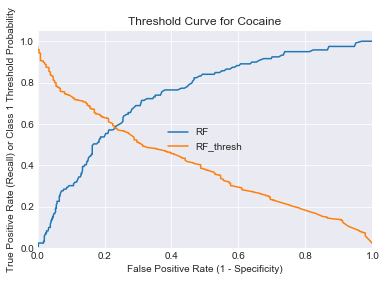

In [1739]:
#Cocaine#
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test_coke, rf_predicted_probs_coke[:,1])

#Lets look at Precision/Recall curve for Linear SVM 
sns.mpl.pyplot.plot(fpr_rf, tpr_rf, label="RF")
sns.mpl.pyplot.plot(fpr_svmlin,thresholds_svmlin, label="RF_thresh")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.title("Threshold Curve for Cocaine")
sns.mpl.pyplot.legend(loc="center")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Recall) or Class 1 Threshold Probability');

In [1746]:
#Playing with threshold on Linear SVM 
y_test_rf_df = pd.DataFrame(
    np.concatenate((
        rf_predicted_probs_coke, 
        rf_coke_pred.reshape((rf_coke_pred.shape[0],-1)),
        y_test_coke.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

#Setting a new threshold value 
#y_test_linsvm_df["predicted_06"] = (y_test_linsvm_df.class_1 > 0.61).astype(float) #False positives 

y_test_rf_df["predicted_02"] = (y_test_rf_df.class_1 > 0.23).astype(float) #False negatives 

y_test_rf_df.head(5)

,class_0,class_1,predicted,actual,predicted_02
0,0.916,0.084,0.0,0.0,0.0
1,0.766,0.234,0.0,0.0,1.0
2,0.812,0.188,0.0,1.0,0.0
3,0.778,0.222,0.0,0.0,0.0
4,0.608,0.392,0.0,0.0,1.0


In [1747]:
print("Confusion matrix at original 0.5 threshold:\n",metrics.confusion_matrix(y_test_rf_df.actual,
                                                                      y_test_rf_df.predicted),"\n")

print("Classification Report at original 0.5 threshold:\n", 
      metrics.classification_report(y_test_rf_df.actual,y_test_rf_df.predicted),"\n")

print("Confusion matrix at 0.4 threshold:\n",metrics.confusion_matrix(y_test_rf_df.actual,
                                                                      y_test_rf_df.predicted_02),"\n")

print("Classification Report at 0.4 threshold:\n", metrics.classification_report(y_test_rf_df.actual,
                                                                                 y_test_rf_df.predicted_02),"\n")

Confusion matrix at original 0.5 threshold:
 [[422  25]
 [ 96  23]] 

Classification Report at original 0.5 threshold:
              precision    recall  f1-score   support

        0.0       0.81      0.94      0.87       447
        1.0       0.48      0.19      0.28       119

avg / total       0.74      0.79      0.75       566
 

Confusion matrix at 0.4 threshold:
 [[290 157]
 [ 31  88]] 

Classification Report at 0.4 threshold:
              precision    recall  f1-score   support

        0.0       0.90      0.65      0.76       447
        1.0       0.36      0.74      0.48       119

avg / total       0.79      0.67      0.70       566
 



In [1830]:
#Linear SVM for Cocaine
lin_svm_coke = svm.SVC(kernel='linear', probability=True)
lin_svm_coke.fit(X_train_scaled_coke, y_train_coke)
print(lin_svm_coke.score(X_test_scaled_coke, y_test_coke))
lin_svm_pred_coke = lin_svm_coke.predict(X_test_scaled_coke)

lin_svm_predicted_probs_coke = lin_svm.predict_proba(X_test_scaled_coke)
print(metrics.confusion_matrix(y_test_coke, lin_svm_pred_coke))
print(metrics.classification_report(y_test_coke, lin_svm_pred_coke))
list(zip(X_test_coke.columns, lin_svm_coke.coef_[0]))

0.67667844523
[[293 145]
 [ 38  90]]
             precision    recall  f1-score   support

          0       0.89      0.67      0.76       438
          1       0.38      0.70      0.50       128

avg / total       0.77      0.68      0.70       566



[('Nscore', 0.16364290360718636),
 ('Escore', 0.15700965708533943),
 ('Oscore', 0.10137946950537469),
 ('Ascore', -0.24236884950124526),
 ('Cscore', -0.18372002362722384),
 ('Impulsive', -0.070714637976696082),
 ('SS', 0.78292586536569786)]

In [1831]:
lin_svm_coke.feature_names = ['Neuroticism: Neurotic individuals are likely to experience feelings \
of anxiety, worry, depression, loneliness and guilt.',
                         'Extraversion: Extroverted individuals tend to be more outgoing and social. They recharge around other people.', 
                         'Openness: Imaginative, curious and open-minded people. Attentiveness to inner feelings and focused on trying new things.',
                         'Agreeableness: Agreeable individuals tend to be more empathetic, caring and cooperative towards other people.', 
                         'Conscientiousness: Goal-oriented, diligent individuals that enjoy having a set schedule and structure. Strong attention to detail.',
                         'Impulsiveness: Impulsive individuals tend to display behavior characterized by having little or no forethought of the consequences of their actions.',
                         'Sensation-Seeking: Excitement-seeking individuals that are easily bored without high levels of stimulation.']
lin_svm_coke.feature_names
targets = ["Non-User", "User"]
lin_svm_coke.target_names = targets
lin_svm_coke.target_names

['Non-User', 'User']

In [1833]:
#Pickling linear svm for nicotine
with open("lin_svm_coke.pkl", "wb") as f:
    pickle.dump(lin_svm_coke, f)

#Testing opening pickled model 
with open("lin_svm_coke.pkl", "rb") as f:
    lin_svm_coke = pickle.load(f)

Ecstasy

In [726]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_e = drug_df.Ecstasy
print(drug_df.Ecstasy.value_counts())
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y_e, test_size=0.3, random_state=1234) 

0    1368
1     517
Name: Ecstasy, dtype: int64


In [727]:
#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_e)
#Transform train
X_train_scaled_e = scaler.transform(X_train_e)
#Transform test 
X_test_scaled_e = scaler.transform(X_test_e)
#Model
rf_ecstasy = RandomForestClassifier(n_estimators=50, random_state=1234)
rf_ecstasy.fit(X_train_scaled_e, y_train_e)
ecstasy_pred = rf_ecstasy.predict(X_test_scaled_e)
print(metrics.accuracy_score(y_test_e, ecstasy_pred))
print(metrics.classification_report(y_test_e, ecstasy_pred))

0.736749116608
             precision    recall  f1-score   support

          0       0.80      0.87      0.83       430
          1       0.44      0.32      0.37       136

avg / total       0.71      0.74      0.72       566



In [728]:
list(zip(X.columns, rf_ecstasy.feature_importances_))

[('Nscore', 0.14272326791923393),
 ('Escore', 0.15068336226025297),
 ('Oscore', 0.15930567167142623),
 ('Ascore', 0.13786724580064191),
 ('Cscore', 0.15476131499623635),
 ('Impulsive', 0.091814439779862325),
 ('SS', 0.16284469757234629)]

Heroin

In [729]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_heroin = drug_df.Heroin
print(drug_df.Heroin.value_counts())
X_train_heroin, X_test_heroin, y_train_heroin, y_test_heroin = train_test_split(X, y_e, 
                                                                                test_size=0.3, random_state=1234) 

0    1767
1     118
Name: Heroin, dtype: int64


In [730]:
#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_heroin)
#Transform train
X_train_scaled_heroin = scaler.transform(X_train_heroin)
#Transform test 
X_test_scaled_heroin = scaler.transform(X_test_heroin)
#Model
rf_heroin = RandomForestClassifier(n_estimators=50)
rf_heroin.fit(X_train_scaled_heroin, y_train_heroin)
heroin_pred = rf_heroin.predict(X_test_scaled_heroin)
print(metrics.accuracy_score(y_test_heroin, heroin_pred))
print(metrics.classification_report(y_test_heroin, heroin_pred))

0.733215547703
             precision    recall  f1-score   support

          0       0.80      0.86      0.83       430
          1       0.43      0.33      0.37       136

avg / total       0.71      0.73      0.72       566



In [731]:
rf_heroin.classes_

array([0, 1])

In [732]:
list(zip(X.columns, rf_heroin.feature_importances_))

[('Nscore', 0.14717130678928464),
 ('Escore', 0.14488433744548387),
 ('Oscore', 0.15645134465268656),
 ('Ascore', 0.14390271553010806),
 ('Cscore', 0.1523361160342242),
 ('Impulsive', 0.09370869548677857),
 ('SS', 0.16154548406143401)]

In [733]:
#Predictions with Heroin Model
print(X.columns)
heroin_predict_probas = rf_heroin.predict_proba([[1.0, 0, 1.34, 0.23, 1.02, -0.1, 0.4]])[0]
print("0: Non User")
print("1: User")
list(zip(rf_heroin.classes_, heroin_predict_probas))

Index(['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS'], dtype='object')
0: Non User
1: User


[(0, 0.66000000000000003), (1, 0.34000000000000002)]

Ketamine

In [790]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_ket = drug_df.Ket
print(drug_df.Ket.value_counts())
X_train_ket, X_test_ket, y_train_ket, y_test_ket = train_test_split(X, y_ket, 
                                                                    test_size=0.3) 

0    1677
1     208
Name: Ket, dtype: int64


In [791]:
#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_ket)
#Transform train
X_train_scaled_ket = scaler.transform(X_train_ket)
#Transform test 
X_test_scaled_ket = scaler.transform(X_test_ket)
#Model
rf_ket = RandomForestClassifier(n_estimators=50)
rf_ket.fit(X_train_scaled_ket, y_train_ket)
ket_pred = rf_ket.predict(X_test_scaled_ket)
print(metrics.accuracy_score(y_test_ket, ket_pred))
print(metrics.classification_report(y_test_ket, ket_pred))

0.871024734982
             precision    recall  f1-score   support

          0       0.87      1.00      0.93       493
          1       0.50      0.03      0.05        73

avg / total       0.83      0.87      0.82       566



In [792]:
print(X.columns)
ketamine_predict_probas = rf_ket.predict_proba([[-1, -3, 0, 0, 1, -2, -1]])[0]
print("0: Non User")
print("1: User")
list(zip(rf_ket.classes_, ketamine_predict_probas))

Index(['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS'], dtype='object')
0: Non User
1: User


[(0, 0.71999999999999997), (1, 0.28000000000000003)]

In [746]:
list(zip(X.columns, rf_ket.feature_importances_))

[('Nscore', 0.15816163724284393),
 ('Escore', 0.17294061807128194),
 ('Oscore', 0.15001423930919452),
 ('Ascore', 0.16236384867677284),
 ('Cscore', 0.14662308374528205),
 ('Impulsive', 0.096035983150589962),
 ('SS', 0.11386058980403473)]

LSD

In [747]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_lsd = drug_df.LSD
print(drug_df.LSD.value_counts())
X_train_lsd, X_test_lsd, y_train_lsd, y_test_lsd = train_test_split(X, y_lsd, 
                                                                    test_size=0.3, random_state=1234) 

0    1505
1     380
Name: LSD, dtype: int64


In [748]:
#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_lsd)
#Transform train
X_train_scaled_lsd = scaler.transform(X_train_lsd)
#Transform test 
X_test_scaled_lsd = scaler.transform(X_test_lsd)
#Model
rf_lsd = RandomForestClassifier(n_estimators=50)
rf_lsd.fit(X_train_scaled_lsd, y_train_lsd)
lsd_pred = rf_lsd.predict(X_test_scaled_lsd)
print(metrics.accuracy_score(y_test_lsd, lsd_pred))
print(metrics.classification_report(y_test_lsd, lsd_pred))

0.796819787986
             precision    recall  f1-score   support

          0       0.83      0.94      0.88       456
          1       0.45      0.22      0.29       110

avg / total       0.76      0.80      0.77       566



In [749]:
list(zip(X.columns, rf_lsd.feature_importances_))

[('Nscore', 0.1444325337029968),
 ('Escore', 0.14247441901780317),
 ('Oscore', 0.18546737803449109),
 ('Ascore', 0.14601156174935606),
 ('Cscore', 0.14849579158764922),
 ('Impulsive', 0.095534903790801026),
 ('SS', 0.13758341211690275)]

In [783]:
print(X.columns)
lsd_predict_probas = rf_lsd.predict_proba([[-1.5, 0.5, 0.5, 0, -1, -0.5, 0.5]])[0]
print("0: Non User")
print("1: User")
list(zip(rf_lsd.classes_, lsd_predict_probas))

Index(['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS'], dtype='object')
0: Non User
1: User


[(0, 0.59999999999999998), (1, 0.40000000000000002)]

In [1208]:
#Linear SVM for LSD
lin_svm_lsd = svm.SVC(kernel='linear', probability=True, class_weight='balanced')
lin_svm_lsd.fit(X_train_scaled_lsd, y_train_lsd)
print(lin_svm_lsd.score(X_test_scaled_lsd, y_test_lsd))
lin_svm_pred_lsd = lin_svm_lsd.predict(X_test_scaled_lsd)

lin_svm_predicted_probs_lsd = lin_svm.predict_proba(X_test_scaled_lsd)
print(metrics.confusion_matrix(y_test_lsd, lin_svm_pred_lsd))
print(metrics.classification_report(y_test_lsd, lin_svm_pred_lsd))
list(zip(X_test_lsd.columns, lin_svm_lsd.coef_[0]))

0.685512367491
[[302 154]
 [ 24  86]]
             precision    recall  f1-score   support

          0       0.93      0.66      0.77       456
          1       0.36      0.78      0.49       110

avg / total       0.82      0.69      0.72       566



[('Nscore', -0.10313207394700896),
 ('Escore', -0.24514879789500732),
 ('Oscore', 0.71905993690594983),
 ('Ascore', -0.048532055025958698),
 ('Cscore', -0.15897501263895464),
 ('Impulsive', -0.097061493755852268),
 ('SS', 0.75838156650242183)]

Shrooms

In [750]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_shrooms = drug_df.Shrooms
print(drug_df.Shrooms.value_counts())
X_train_shrooms, X_test_shrooms, y_train_shrooms, y_test_shrooms = train_test_split(X, y_shrooms, 
                                                                    test_size=0.3, random_state=1234) 

0    1451
1     434
Name: Shrooms, dtype: int64


In [751]:
#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_shrooms)
#Transform train
X_train_scaled_shrooms = scaler.transform(X_train_shrooms)
#Transform test 
X_test_scaled_shrooms = scaler.transform(X_test_shrooms)
#Model
rf_shrooms = RandomForestClassifier(n_estimators=50)
rf_shrooms.fit(X_train_scaled_shrooms, y_train_shrooms)
shrooms_pred = rf_shrooms.predict(X_test_scaled_shrooms)
print(metrics.accuracy_score(y_test_shrooms, shrooms_pred))
print(metrics.classification_report(y_test_shrooms, shrooms_pred))

0.775618374558
             precision    recall  f1-score   support

          0       0.81      0.93      0.87       440
          1       0.49      0.24      0.32       126

avg / total       0.74      0.78      0.74       566



In [752]:
list(zip(X.columns, rf_shrooms.feature_importances_))

[('Nscore', 0.15149175607511176),
 ('Escore', 0.1514081301319215),
 ('Oscore', 0.1770005325971542),
 ('Ascore', 0.14940148716706247),
 ('Cscore', 0.1402248970906754),
 ('Impulsive', 0.094941026644682486),
 ('SS', 0.13553217029339218)]

Nicotine

In [1361]:
X = drug_df.iloc[:, [3, 4, 5, 6, 7, 8, 9]]
y_nic = drug_df.Nicotine
print(drug_df.Nicotine.value_counts())
X_train_nic, X_test_nic, y_train_nic, y_test_nic = train_test_split(X, y_nic, 
                                                                    test_size=0.3) 

1    1060
0     825
Name: Nicotine, dtype: int64


In [1362]:
#Standardize the personality trait features before running random forests
#Scale X dataset for random forests
scaler.fit(X_train_nic)
#Transform train
X_train_scaled_nic = scaler.transform(X_train_nic)
#Transform test 
X_test_scaled_nic = scaler.transform(X_test_nic)
#Model
rf_nic = RandomForestClassifier(n_estimators=800)
rf_nic.fit(X_train_scaled_nic, y_train_nic)
nic_pred = rf_nic.predict(X_test_scaled_nic)
print(metrics.accuracy_score(y_test_nic, nic_pred))
print(metrics.classification_report(y_test_nic, nic_pred))
print(metrics.confusion_matrix(y_test_nic, nic_pred))

0.696113074205
             precision    recall  f1-score   support

          0       0.64      0.61      0.63       236
          1       0.73      0.76      0.74       330

avg / total       0.69      0.70      0.69       566

[[144  92]
 [ 80 250]]


In [1363]:
list(zip(X.columns, rf_nic.feature_importances_))

[('Nscore', 0.15589169071360814),
 ('Escore', 0.14404351954545297),
 ('Oscore', 0.16687904325292408),
 ('Ascore', 0.14740827061791115),
 ('Cscore', 0.15210888059476621),
 ('Impulsive', 0.095612542452662305),
 ('SS', 0.13805605282267522)]

In [1713]:
#SVMs for Nicotine
lin_svm_nic = svm.SVC(kernel='linear', probability=True)
lin_svm_nic.fit(X_train_scaled_nic, y_train_nic)
print(lin_svm_nic.score(X_test_scaled_nic, y_test_nic))
lin_svm_pred_nic = lin_svm_nic.predict(X_test_scaled_nic)

lin_svm_predicted_probs_nic = lin_svm.predict_proba(X_test_scaled_nic)
print(metrics.confusion_matrix(y_test_nic, lin_svm_pred_nic))
print(metrics.classification_report(y_test_nic, lin_svm_pred_nic))
list(zip(X_test_nic.columns, lin_svm_nic.coef_[0]))

0.722614840989
[[146  90]
 [ 67 263]]
             precision    recall  f1-score   support

          0       0.69      0.62      0.65       236
          1       0.75      0.80      0.77       330

avg / total       0.72      0.72      0.72       566



[('Nscore', 0.11096021360268793),
 ('Escore', -0.086995425984845554),
 ('Oscore', 0.30798073217331279),
 ('Ascore', -0.043426288629540011),
 ('Cscore', -0.25890165369457918),
 ('Impulsive', 0.045735951888566717),
 ('SS', 0.54039034236845396)]

In [1718]:
lin_svm_nic.feature_names = ['Neuroticism: Neurotic individuals are likely to experience feelings \
of anxiety, worry, depression, loneliness and guilt.',
                         'Extraversion: Extroverted individuals tend to be more outgoing and social. They recharge around other people.', 
                         'Openness: Imaginative, curious and open-minded people. Attentiveness to inner feelings and focused on trying new things.',
                         'Agreeableness: Agreeable individuals tend to be more empathetic, caring and cooperative towards other people.', 
                         'Conscientiousness: Goal-oriented, diligent individuals that enjoy having a set schedule and structure. Strong attention to detail.',
                         'Impulsiveness: Impulsive individuals tend to display behavior characterized by having little or no forethought of the consequences of their actions.',
                         'Sensation-Seeking: Excitement-seeking individuals that are easily bored without high levels of stimulation.']
lin_svm_nic.feature_names
targets = ["Non-User", "User"]
lin_svm_nic.target_names = targets
lin_svm_nic.target_names

['Non-User', 'User']

In [1721]:
#Pickling linear svm for nicotine
with open("lin_svm_nic.pkl", "wb") as f:
    pickle.dump(lin_svm_nic, f)

In [1722]:
#Testing opening pickled model 
with open("lin_svm_nic.pkl", "rb") as f:
    lin_svm_nic_pickle = pickle.load(f)

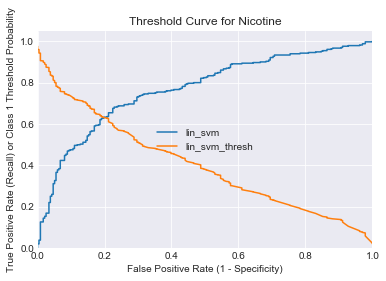

In [1699]:
#NICOTINE#
fpr_svmlin, tpr_svmlin, thresholds_svmlin = metrics.roc_curve(y_test_nic, lin_svm_predicted_probs_nic[:,1])
#Lets look at Precision/Recall curve for Linear SVM 
sns.mpl.pyplot.plot(fpr_svmlin, tpr_svmlin,label="lin_svm")
sns.mpl.pyplot.plot(fpr_svmlin,thresholds_svmlin, label="lin_svm_thresh")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.title("Threshold Curve for Nicotine")
sns.mpl.pyplot.legend(loc="center")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Recall) or Class 1 Threshold Probability');


In [1711]:
#Playing with threshold on Linear SVM 
y_test_linsvm_df = pd.DataFrame(
    np.concatenate((
        lin_svm_predicted_probs_nic, 
        lin_svm_pred_nic.reshape((lin_svm_pred_nic.shape[0],-1)),
        y_test_nic.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

#Setting a new threshold value 
#y_test_linsvm_df["predicted_06"] = (y_test_linsvm_df.class_1 > 0.61).astype(float) #False positives 

y_test_linsvm_df["predicted_04"] = (y_test_linsvm_df.class_1 > 0.4).astype(float) #False negatives 

y_test_linsvm_df.head(5)

,class_0,class_1,predicted,actual,predicted_04
0,0.550613,0.449387,0.0,0.0,1.0
1,0.871884,0.128116,0.0,1.0,0.0
2,0.281236,0.718764,1.0,1.0,1.0
3,0.487178,0.512822,1.0,1.0,1.0
4,0.806482,0.193518,0.0,0.0,0.0


In [1712]:
print("Confusion matrix at original 0.5 threshold:\n",metrics.confusion_matrix(y_test_linsvm_df.actual,
                                                                      y_test_linsvm_df.predicted),"\n")

print("Classification Report at original 0.5 threshold:\n", 
      metrics.classification_report(y_test_linsvm_df.actual,y_test_linsvm_df.predicted),"\n")

print("Confusion matrix at 0.4 threshold:\n",metrics.confusion_matrix(y_test_linsvm_df.actual,
                                                                      y_test_linsvm_df.predicted_04),"\n")

print("Classification Report at 0.4 threshold:\n", metrics.classification_report(y_test_linsvm_df.actual,
                                                                                 y_test_linsvm_df.predicted_04),"\n")

Confusion matrix at original 0.5 threshold:
 [[146  90]
 [ 67 263]] 

Classification Report at original 0.5 threshold:
              precision    recall  f1-score   support

        0.0       0.69      0.62      0.65       236
        1.0       0.75      0.80      0.77       330

avg / total       0.72      0.72      0.72       566
 

Confusion matrix at 0.4 threshold:
 [[121 115]
 [ 66 264]] 

Classification Report at 0.4 threshold:
              precision    recall  f1-score   support

        0.0       0.65      0.51      0.57       236
        1.0       0.70      0.80      0.74       330

avg / total       0.68      0.68      0.67       566
 



 # Multilabel Experimentation
 
 Random Forest Classifier

In [1247]:
#Multilabel Time
X = drug_df.drop(['Alc', 'Benzos', 'Weed', 'Coke',
                  'Ecstasy', 'Heroin', 'Ket', 'LSD',
                  'Shrooms', 'Nicotine'], axis=1)

y = drug_df.l oc[:, ['Alc', 'Benzos', 'Weed', 'Coke', 
                    'Ecstasy', 'Heroin', 'Ket', 'LSD', 
                    'Shrooms', 'Nicotine']]

In [1248]:
#Train Test Split
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(X, y, test_size = 0.3)

In [1256]:
#Model
rf_mult = RandomForestClassifier(n_estimators=950)

#Class Weights
#[{0:10, 1:1},{0:1, 1:2.5},{0:1, 1:1},
# {0:1, 1:3},{0:1, 1:2.5},{0:1, 1:10},
# {0:1, 1:5},{0:1,1:4},{0:1, 1:4},
# {0:1, 1:1}]

rf_mult.fit(X_train_mult, y_train_mult)
y_pred_mult = rf_mult.predict(X_test_mult)

In [1257]:
for i in y_train_mult.columns:
    print(y_train_mult[i].value_counts())

1    1224
0      95
Name: Alc, dtype: int64
0    941
1    378
Name: Benzos, dtype: int64
1    711
0    608
Name: Weed, dtype: int64
0    1023
1     296
Name: Coke, dtype: int64
0    949
1    370
Name: Ecstasy, dtype: int64
0    1233
1      86
Name: Heroin, dtype: int64
0    1171
1     148
Name: Ket, dtype: int64
0    1047
1     272
Name: LSD, dtype: int64
0    1007
1     312
Name: Shrooms, dtype: int64
1    742
0    577
Name: Nicotine, dtype: int64


In [1258]:
list(zip(y_test_mult, rf_mult.classes_))

[('Alc', array([0, 1])),
 ('Benzos', array([0, 1])),
 ('Weed', array([0, 1])),
 ('Coke', array([0, 1])),
 ('Ecstasy', array([0, 1])),
 ('Heroin', array([0, 1])),
 ('Ket', array([0, 1])),
 ('LSD', array([0, 1])),
 ('Shrooms', array([0, 1])),
 ('Nicotine', array([0, 1]))]

In [1259]:
print("Multilabel Test Accuracy Score:", accuracy_score(y_test_mult, y_pred_mult))
print("Multilabel Test F1 Score:", metrics.f1_score(y_test_mult, y_pred_mult, average='weighted'))

Multilabel Test Accuracy Score: 0.3074204947
Multilabel Test F1 Score: 0.739400241004


In [1260]:
pd.DataFrame({'Feature':X_test_mult.columns,
              'Importance':rf_mult.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
5,Oscore,0.090279
9,SS,0.086610
7,Cscore,0.084979
3,Nscore,0.082786
10,Amphet,0.080864
6,Ascore,0.080445
4,Escore,0.078646
0,Age,0.077839
8,Impulsive,0.060679
2,Education,0.059488


In [1261]:
print(metrics.classification_report(y_test_mult, y_pred_mult))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96       525
          1       0.75      0.56      0.64       157
          2       0.83      0.89      0.86       288
          3       0.73      0.39      0.51       121
          4       0.73      0.56      0.64       147
          5       0.25      0.03      0.06        32
          6       1.00      0.03      0.06        60
          7       0.68      0.56      0.61       108
          8       0.56      0.50      0.53       122
          9       0.73      0.80      0.76       318

avg / total       0.79      0.73      0.74      1878



In [1255]:
drug_df.columns

Index(['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore',
       'Cscore', 'Impulsive', 'SS', 'Alc', 'Amphet', 'Benzos', 'Caffeine',
       'Weed', 'Chocolate', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ket', 'LSD',
       'Meth', 'Shrooms', 'Nicotine', 'USA', 'NZ', 'Other', 'Australia',
       'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed_WB',
       'Other', 'Mixed_WA', 'Mixed_BA'],
      dtype='object')